### AutoML 01: Classification with Local Compute
In this example we use the scikit-learn's digit dataset to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the 00.configuration before running this notebook.

In this notebook you will learn how to:

Create an Experiment in an existing Workspace.
Configure AutoML using AutoMLConfig.
Train the model using local compute.
Explore the results.
Test the best fitted model.
Create an Experiment
As part of the setup you have already created an Azure ML Workspace object. For AutoML you will need to create an Experiment object, which is a named object in a Workspace used to run experiments.

In [51]:
#Load all the necessary libraries
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np
import os

In [52]:
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
#from tensorflow import keras
import itertools

In [53]:
subscription_id = "1e30ba0a-66fa-4479-9bca-95ba2cf71b20"
resource_group = "azmlexp"
workspace_name = "mymlworkspace"
workspace_region = "eastus2"

In [4]:
# Import the Workspace class and check the Azure ML SDK version.
#from azureml.core import Workspace

#ws = Workspace.create(name = workspace_name,
#                      subscription_id = subscription_id,
#                      resource_group = resource_group, 
#                      location = workspace_region)
#ws.get_details()

In [6]:
#Validate you have access to the workspace and create a config file from the workspace
#from azureml.core import Workspace

#ws = Workspace(workspace_name = workspace_name,
#               subscription_id = subscription_id,
#               resource_group = resource_group)
#
# Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
#ws.write_config()

Wrote the config file config.json to: /Users/trinakarmakar/codelibs/aml_config/config.json


In [54]:
#Load the wokspace and get details
# Load workspace configuration from ./aml_config/config.json file.
my_workspace = Workspace.from_config()
my_workspace.get_details()

Found the config file in: /Users/trinakarmakar/codelibs/aml_config/config.json


{'applicationInsights': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/azmlexp/providers/microsoft.insights/components/mymlworkinsightsiuiukpxg',
 'batchaiWorkspace': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/azmlexp/providers/microsoft.batchai/workspaces/mymlworkbatchai_lybletfw',
 'containerRegistry': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/azmlexp/providers/microsoft.containerregistry/registries/mymlworkacrezcgyngt',
 'description': '',
 'friendlyName': 'mymlworkspace',
 'id': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourceGroups/azmlexp/providers/Microsoft.MachineLearningServices/workspaces/mymlworkspace',
 'identityPrincipalId': 'b8b69460-50de-436f-a469-d5e88c606e3e',
 'identityTenantId': '72f988bf-86f1-41af-91ab-2d7cd011db47',
 'identityType': 'SystemAssigned',
 'keyVault': '/subscriptions/1e30ba0a-66fa-4479-9bca-95ba2cf71b20/resourcegroups/azmlexp/providers/microsoft.keyvault/vaults/mymlwork

Import the Fashion MNIST dataset
This guide uses the Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

Fashion MNIST sprite

<img src="fashion.png">

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, just import and load the data:

In [55]:
# Import Fashion MNIST
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [56]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_images.shape))
print("Training set (labels) shape: {shape}".format(shape=train_labels.shape))
# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_images.shape))
print("Test set (labels) shape: {shape}".format(shape=test_labels.shape))

Training set (images) shape: (60000, 28, 28)
Training set (labels) shape: (60000,)
Test set (images) shape: (10000, 28, 28)
Test set (labels) shape: (10000,)


In [8]:
# Create dictionary of target classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

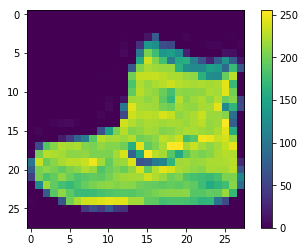

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

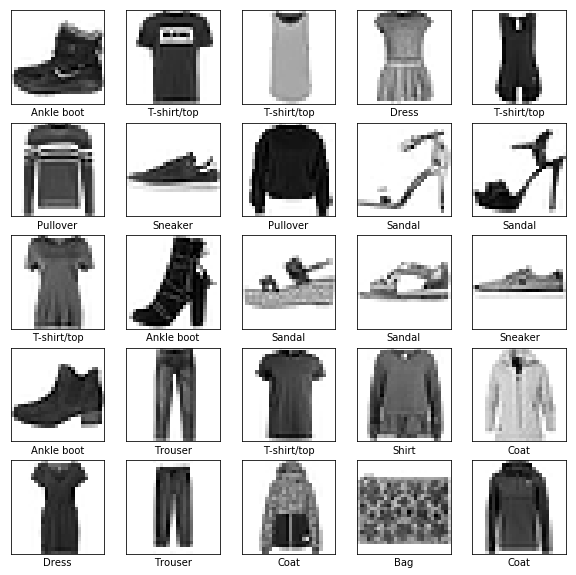

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [11]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging

In [12]:
#Configure workspace
from azureml.core import Workspace
ws = Workspace.from_config()
#Project folder to save your local files
project_folder = './sample_projects/automl/fasionMNIST'
#choose a name for the run history container in the workspace
experiment_name = 'automl-flashion-mnist-classifier'

Found the config file in: /Users/trinakarmakar/codelibs/aml_config/config.json


In [13]:
output = {}
output['sdk_version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

,
Location,eastus2
Project Directory,./sample_projects/automl/fasionMNIST
Resource Group,azmlexp
Subscription ID,1e30ba0a-66fa-4479-9bca-95ba2cf71b20
Workspace,mymlworkspace
sdk_version,0.1.74


In [59]:
train_labels = train_labels.astype(np.int32)
print(train_images.shape)

(60000, 28, 28)


In [60]:
train_images = train_images.reshape(train_images.shape[0], 784)
print(train_images.shape)

(60000, 784)


In [61]:
test_images = test_images.reshape(test_images.shape[0], 784)
print(test_images.shape)

(10000, 784)


In [62]:
from azureml.train.automl import AutoMLConfig
Automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             max_time_sec = 12000,
                             iterations = 2,
                             n_cross_validations = 3,
                             preprocess = False,
                             exit_score = 0.97,
                             blacklist_algos = ['kNN','LinearSVM'],
                             X = train_images,
                             y = train_labels,
                             path=project_folder)

In [63]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_4271bb46-2071-405f-9f3b-88d4d2038761
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      MaxAbsScaler LightGBMClassifier       0:01:44.382609           0.985     0.985
Stopping criteria reached at iteration 1. Ending experiment.

In [64]:
from azureml.train.widgets import RunDetails
RunDetails(local_run).show()

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

In [65]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()

# register model in workspace
from sklearn.externals import joblib
description = 'Automated Machine Learning Model for Fashion MNIST'
tags = "Fashion MNIST"
os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=fitted_model, filename='./outputs/fashion_mnist_model.pkl')

['./outputs/fashion_mnist_model.pkl']

### Register theFitted Model for Deployment
If neither metric nor iteration are specified in the register_model call, the iteration with the best primary metric is registered.

In [66]:
description = 'AutoML Model'
tags = None
model = local_run.register_model(description = description, tags = tags)
local_run.model_id # This will be written to the script file later in the notebook.

Registering model AutoML4271bb462best


'AutoML4271bb462best'

### Create the scoring script, called score.py, used by the web service call to show how to use the model.

You must include two required functions into the scoring script:

The init() function, which typically loads the model into a global object. This function is run only once when the Docker container is started.

The run(input_data) function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.

In [67]:
%%writefile score.py
import pickle
import json
import numpy
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(rawdata):
    try:
        data = json.loads(rawdata)['data']
        data = numpy.array(data)
        result = model.predict(data)
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Overwriting score.py


In [68]:
experiment_name = 'automl-local-classification'

experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)

In [76]:
ml_run.get_run_sdk_dependencies()

Iteration number is not passed, retrieve the environment for the parent run.
No issues found in the SDK package versions.


{'azureml-core': '0.1.74',
 'azureml-dataprep': '0.3.0',
 'azureml-dataprep-native': '10.4.0',
 'azureml-pipeline': '0.1.74',
 'azureml-pipeline-core': '0.1.74',
 'azureml-pipeline-steps': '0.1.74',
 'azureml-sdk': '0.1.74',
 'azureml-telemetry': '0.1.74',
 'azureml-train': '0.1.74',
 'azureml-train-automl': '0.1.74',
 'azureml-train-core': '0.1.74',
 'azureml-train-restclients-hyperdrive': '0.1.74',
 'azureml-train-widgets': '0.1.74'}

In [83]:
dependencies = ml_run.get_run_sdk_dependencies(iteration = 0)

No issues found in the SDK package versions.


In [84]:
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	0.1.74
azureml-sdk	0.1.74
azureml-core	0.1.74


In [85]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-sdk[automl]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [86]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

### Create a Container Image

In [87]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "digits", 'type': "automl_classification"},
                                 description = "Image for automl classification sample")

image = Image.create(name = "automlsampleimage",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running...................................................
SucceededImage creation operation finished for image automlsampleimage:1, operation "Succeeded"


### Deploy as web service
Once you've tested the model and are satisfied with the results, deploy the model as a web service hosted in ACI.

To build the correct environment for ACI, provide the following:

A scoring script to show how to use the model
An environment file to show what packages need to be installed
A configuration file to build the ACI
The model you trained before
Create scoring script

In [88]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "digits", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

In [89]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-sample-01'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-01
Creating service
Running.................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


### Delete the service

In [ ]:
#aci_service.delete()

### Get Logs from a Deployed Web Service

In [ ]:
#aci_service.get_logs()

84


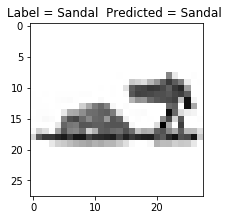

49


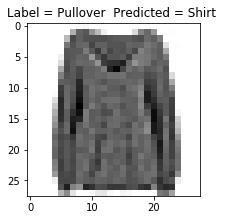

16


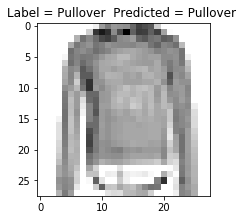

In [97]:
#Randomly select digits and test
import json
test_images = test_images.reshape(test_images.shape[0], 784)
test_labels = test_labels.astype(np.int32)
X_test = test_images[:100, :]
y_test = test_labels[:100]
for index in np.random.choice(len(y_test), 3, replace = False):
    print(index)
    test_sample = json.dumps({'data':X_test[index:index + 1].tolist()})
    predicted = aci_service.run(input_data = test_sample)
    label = y_test[index]
    predictedDict = json.loads(predicted)
    title = "Label = %s  Predicted = %s " % ( class_names[label],class_names[predictedDict['result'][0]])
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(test_images[index].reshape(28, 28), cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

In [25]:
def plot_image(i, predictions, true_labels, img):
  prediction, true_label, img = predictions[i], true_labels[i], img[i]
  img = img.reshape(28,28)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = prediction
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)

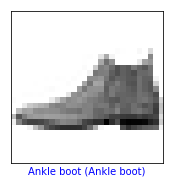

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)

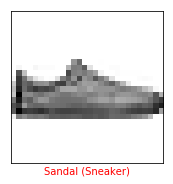

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)

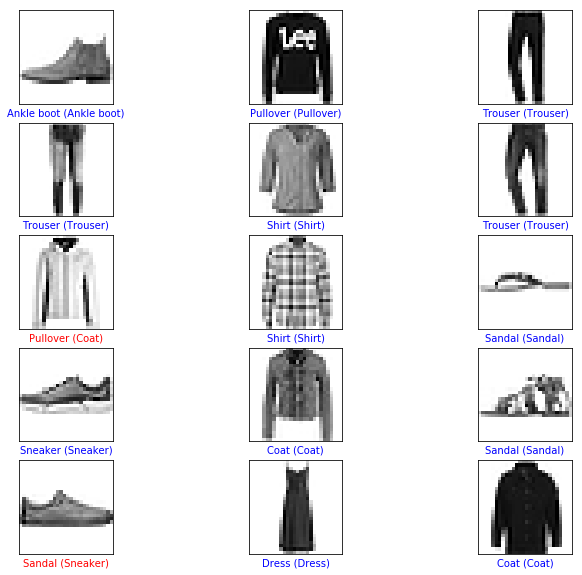

In [28]:
#Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)

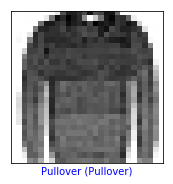

In [29]:
i = 20
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)

In [30]:
from azureml.core import Workspace
from azureml.core.model import Model

#ws = Workspace.from_config()
#ws.get_details()
model=Model(ws, 'fashion_mnist')
model.download(target_dir = '.')
import os 
# verify the downloaded model file
os.stat('fashion_mnist_model.pkl')

os.stat_result(st_mode=33188, st_ino=4312670760, st_dev=16777220, st_nlink=1, st_uid=501, st_gid=20, st_size=442092, st_atime=1543172330, st_mtime=1543172330, st_ctime=1543172435)

In [31]:
import pickle
from sklearn.externals import joblib

clf = joblib.load('fashion_mnist_model.pkl')
predictions = clf.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, predictions)
print(conf_mx)
print('Overall accuracy:', np.average(predictions==y_test))

[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0  0 11  1  1  0  1  0  0  0]
 [ 1  0  0  7  1  0  0  0  0  0]
 [ 0  0  3  0  6  0  1  0  0  0]
 [ 0  0  0  0  0  8  0  1  0  0]
 [ 1  0  1  0  1  0  5  0  0  0]
 [ 0  0  0  0  0  1  0  9  0  1]
 [ 0  0  0  0  0  0  1  0 11  0]
 [ 0  0  0  0  0  1  0  1  0  4]]
Overall accuracy: 0.82


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 7  0  0  1  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0  0 10  1  3  0  0  0  0  0]
 [ 0  1  0  6  2  0  0  0  0  0]
 [ 0  0  5  0  4  0  1  0  0  0]
 [ 0  0  0  0  0  8  0  1  0  0]
 [ 1  0  1  0  2  0  4  0  0  0]
 [ 0  0  0  0  0  1  0  9  0  1]
 [ 0  0  1  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  1  0  2  0  3]]
Normalized confusion matrix
[[0.88 0.   0.   0.12 0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.71 0.07 0.21 0.   0.   0.   0.   0.  ]
 [0.   0.11 0.   0.67 0.22 0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.   0.4  0.   0.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.89 0.   0.11 0.   0.  ]
 [0.12 0.   0.12 0.   0.25 0.   0.5  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.09 0.   0.82 0.   0.09]
 [0.   0.   0.08 0.   0.   0.   0.   0.   0.92 0.  ]
 [0.   0.   0.   0.   0.   0.17 0.   0.33 0.   0.5 ]]


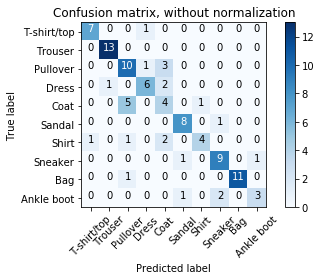

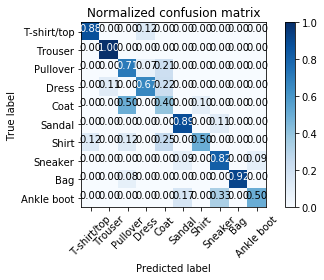

In [90]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

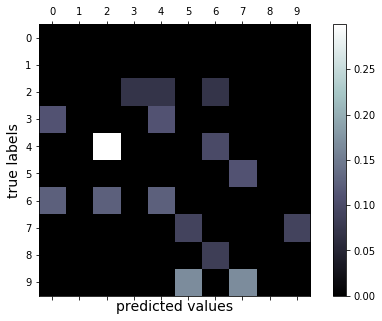

In [37]:
#normalize the diagnal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()